In [69]:
NOTEBOOK_NAME = "e009_era_improve"

In [70]:
import numpy as np
import polars as pl
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
import japanize_matplotlib

In [71]:
train = pl.read_csv("../data/train.csv")
test = pl.read_csv("../data/test.csv")
era = pl.read_csv("../data/era_improve.csv")
sample_submission = pl.read_csv("../data/sample_submission.csv")

# 前処理

In [72]:
import re


def get_prefecture(text: str) -> str | None:
    all_prefectures = (
        "北海道|青森県|岩手県|宮城県|秋田県|山形県|福島県|"
        + "茨城県|栃木県|群馬県|埼玉県|千葉県|東京都|神奈川県|"
        + "新潟県|富山県|石川県|福井県|山梨県|長野県|岐阜県|静岡県|愛知県|"
        + "三重県|滋賀県|京都府|大阪府|兵庫県|奈良県|和歌山県|"
        + "鳥取県|島根県|岡山県|広島県|山口県|"
        + "徳島県|香川県|愛媛県|高知県|"
        + "福岡県|佐賀県|長崎県|熊本県|大分県|宮崎県|鹿児島県|沖縄県"
    )
    if match := re.search(all_prefectures, text):
        return match.group(0)
    else:
        return None


# 都道府県を抽出
train = train.with_columns(
    pl.col("都道府県 ※美工品は「所有者住所（所在都道府県）」").apply(get_prefecture).alias("都道府県")
)
test = test.with_columns(
    pl.col("都道府県 ※美工品は「所有者住所（所在都道府県）」").apply(get_prefecture).alias("都道府県")
)

train = train.with_columns(pl.col("所在地").apply(get_prefecture).alias("所在地_都道府県"))
test = test.with_columns(pl.col("所在地").apply(get_prefecture).alias("所在地_都道府県"))

In [73]:
# 種別2より建造物か美工品かを分類する特徴を追加
kenzoubutu_feat = [
    "近世以前／神社",
    "近世以前／神社",
    "近世以前／寺院",
    "近世以前／城郭",
    "近世以前／住宅",
    "近世以前／民家",
    "近世以前／その他",
    "近代／宗教",
    "近代／学校",
    "近代／官公庁舎",
    "近代／産業・交通・土木",
    "近代／住居",
    "近代／文化施設",
    "近代／商業・業務",
    "近代／その他",
]

bikouhin_feat = ["宝", "絵画", "彫刻", "工芸品", "書跡・典籍", "古文書", "考古資料", "歴史資料"]


def classify_kenzoubutu_bikouhin(text: str | None) -> str | None:
    if text in kenzoubutu_feat:
        return "建造物"
    elif text in bikouhin_feat:
        return "美工品"
    return None


train = train.with_columns(
    pl.col("種別2").apply(classify_kenzoubutu_bikouhin).alias("建造物_or_美工品")
)
test = test.with_columns(
    pl.col("種別2").apply(classify_kenzoubutu_bikouhin).alias("建造物_or_美工品")
)

/var/folders/4p/kqrm_mh10fn2pjkrxfzxh03c0000gq/T/ipykernel_19542/1010906722.py:32: PolarsInefficientApplyWarning: 
Expr.apply is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `apply` with the following:
  - pl.col("種別2").apply(classify_kenzoubutu_bikouhin)
  + pl.col("種別2").is_in(kenzoubutu_feat) & '建造物' & '美工品'

  pl.col("種別2").apply(classify_kenzoubutu_bikouhin).alias("建造物_or_美工品")
/var/folders/4p/kqrm_mh10fn2pjkrxfzxh03c0000gq/T/ipykernel_19542/1010906722.py:35: PolarsInefficientApplyWarning: 
Expr.apply is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `apply` with the following:
  - pl.col("種別2").apply(classify_kenzoubutu_bikouhin)
  + pl.col("種別2").is_in(kenzoubutu_feat) & '建造物' & '美工品'

  pl.col("種別2").apply(classify_kenzoubutu_bikouhin).alias("建造物_or_美工品")


In [74]:
def classify_kenzoubutu_genre(text: str | None) -> str | None:
    if text == "近世以前／神社":
        return "神社"
    elif text == "近世以前／寺院":
        return "寺院"
    elif text == "近世以前／城郭":
        return "城郭"
    elif text == "近世以前／住宅":
        return "住宅"
    elif text == "近世以前／民家":
        return "民家"
    elif text == "近世以前／その他":
        return "その他"
    elif text == "近代／宗教":
        return "宗教"
    elif text == "近代／学校":
        return "学校"
    elif text == "近代／官公庁舎":
        return "官公庁舎"
    elif text == "近代／産業・交通・土木":
        return "産業・交通・土木"
    elif text == "近代／住居":
        return "住居"
    elif text == "近代／文化施設":
        return "文化施設"
    elif text == "近代／商業・業務":
        return "商業・業務"
    elif text == "近代／その他":
        return "その他"  # ここはその他で被っている
    return None


train = train.with_columns(
    pl.col("種別2").apply(classify_kenzoubutu_genre).alias("建造物_種類")
)
test = test.with_columns(pl.col("種別2").apply(classify_kenzoubutu_genre).alias("建造物_種類"))

/var/folders/4p/kqrm_mh10fn2pjkrxfzxh03c0000gq/T/ipykernel_19542/808284332.py:34: PolarsInefficientApplyWarning: 
Expr.apply is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `apply` with the following:
  - pl.col("種別2").apply(classify_kenzoubutu_genre)
  + (pl.col("種別2") == '近世以前／神社') & '神社' & '寺院' & '城郭' & '住宅' & '民家' & 'その他' & '宗教' & '学校' & '官公庁舎' & '産業・交通・土木' & '住居' & '文化施設' & '商業・業務' & 'その他'

  pl.col("種別2").apply(classify_kenzoubutu_genre).alias("建造物_種類")
/var/folders/4p/kqrm_mh10fn2pjkrxfzxh03c0000gq/T/ipykernel_19542/808284332.py:36: PolarsInefficientApplyWarning: 
Expr.apply is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `apply` with the following:
  - pl.col("種別2").apply(classify_kenzoubutu_genre)
  + (pl.col("種別2") == '近世以前／神社') & '神社' & '寺院' & '城郭' & '住宅' & '

In [75]:
# 時代を取得する
import re


def get_era(text: str) -> str | None:
    all_era = [
        "鎌倉",
        "元",
        "古墳",
        "江戸",
        "高麗",
        "室町",
        "昭和",
        "大正",
        "唐",
        "桃山",
        "奈良",
        "縄文",
        "縄文",
        "南宋",
        "南北朝",
        "飛鳥",
        "平安",
        "北宋",
        "明治",
        "弥生",
        "明",
    ]
    for era in all_era:
        if era in text:
            return era
    return None


# 時代を抽出
train = train.with_columns(pl.col("時代").apply(get_era).alias("時代_抽出"))
test = test.with_columns(pl.col("時代").apply(get_era).alias("時代_抽出"))

In [76]:
def get_shoyusya_genre(text: str) -> str | None:
    words = [
        "神宮",
        "八幡宮",
        "神社",
        "株式会社",
        "有限会社",
        "研究機構",
        "独立行政法人",
        "公益財団法人",
        "財団法人",
        "学校法人",
        "大学",
        "県",
        "市",
        "区",
        "国",
        "寺",
    ]
    for word in words:
        if word in text:
            return word
    return None


train = train.with_columns(pl.col("所有者名").apply(get_shoyusya_genre).alias("所有者名_genre"))
test = test.with_columns(pl.col("所有者名").apply(get_shoyusya_genre).alias("所有者名_genre"))

In [77]:
# zidai_list = [
#     ["鎌倉", 1185, 1333],
#     ["平安", 794, 1185],
#     ["明治", 1868, 1912],
#     ["桃山", 1573, 1603],
#     ["江戸中期", 1603, 1868],
#     ["室町", 1336, 1573],
#     ["南北朝", 1337, 1392],
#     ["江戸前期", 1603, 1868],
#     ["江戸", 1603, 1868],
#     ["江戸後期", 1603, 1868],
#     ["奈良", 710, 794],
#     ["江戸末期", 1603, 1868],
#     ["室町後期", 1336, 1573],
#     ["南宋", 1127, 1279],
#     ["大正", 1912, 1926],
#     ["昭和", 1926, 1989],
#     ["室町前期", 1336, 1573],
#     ["鎌倉後期", 1185, 1333],
#     ["古墳", 250, 538],
#     ["室町中期", 1336, 1573],
#     ["元", 1271, 1368],
#     ["飛鳥", 592, 710],
#     ["縄文", -14000, -400],
#     ["唐", 618, 907],
#     ["弥生", -400, 350],
#     ["明", 1368, 1644],
#     ["鎌倉前期", 1185, 1333],
#     ["高麗", 918, 1392],
#     ["平安時代", 794, 1185],
#     ["北宋", 960, 1126],
#     ["平安～鎌倉", 794, 1333],
#     ["鎌倉～江戸", 1185, 1868],
#     ["鎌倉時代", 1185, 1333],
#     ["鎌倉～南北朝", 1185, 1392],
#     ["平安後期", 794, 1185],
#     ["鎌倉～室町", 1185, 1573],
#     ["南北朝～室町", 1336, 1573],
#     ["平安～江戸", 794, 1868],
#     ["近代", 0, 0],
#     ["江戸時代", 1603, 1868],
#     ["室町時代", 1336, 1573],
#     ["江戸～明治", 1603, 1912],
#     ["殷", 0, 0],
#     ["平安～南北朝", 794, 1392],
#     ["鎌倉～南北朝～室町", 1185, 1573],
#     ["李朝", 0, 0],
#     ["安土桃山", 0, 0],
#     ["奈良～平安", 710, 1185],
#     ["南北朝時代", 1337, 1392],
#     ["16世紀", 0, 0],
#     ["欧米\u300019世紀", 0, 0],
#     ["任那", 0, 0],
#     ["南宋時代", 1127, 1279],
#     ["清", 0, 0],
#     ["平安～室町", 794, 1573],
#     ["平安前期", 794, 1185],
#     ["旧石器", 0, 0],
#     ["西周", 0, 0],
#     ["奈良～室町", 710, 1573],
#     ["室町～桃山", 1336, 1603],
#     ["北魏", 0, 0],
#     ["元～南北朝", 1271, 1392],
#     ["平安～明治", 794, 1912],
#     ["桃山時代", 1573, 1603],
#     ["南宋～鎌倉", 1127, 1333],
#     ["奈良～江戸", 710, 1868],
#     ["鎌倉～桃山", 1185, 1603],
#     ["奈良～南北朝", 710, 1392],
#     ["縄文時代", -14000, -400],
#     ["東魏", 0, 0],
#     ["宋", 0, 0],
#     ["室町～明治", 1336, 1912],
#     ["南北朝～江戸", 1337, 1868],
#     ["桃山～江戸", 1573, 1868],
#     ["平安～桃山", 794, 1603],
#     ["昭和時代", 1926, 1989],
#     ["古墳時代中期", 250, 538],
#     ["晋", 0, 0],
#     ["黎時代", 0, 0],
#     ["大正時代", 1912, 1926],
#     ["明時代", 1368, 1644],
#     ["弥生時代後期", -400, 350],
#     ["鎌倉～明治時代", 1185, 1912],
#     ["弥生時代", -400, 350],
#     ["新羅", 0, 0],
#     ["南宋～元", 1127, 1368],
#     ["明治～昭和", 1868, 1989],
#     ["鎌倉中期", 1185, 1333],
#     ["室町～安土桃山", 1336, 1573],
#     ["飛鳥～江戸", 592, 1868],
#     ["室町～鎌倉", 1185, 1573],
#     ["宋時代", 0, 0],
#     ["縄文草創期", 0, 0],
#     ["安土桃山時代～江戸時代", 1603, 1868],
#     ["古墳時代", 250, 538],
#     ["14世紀", 0, 0],
#     ["姚秦", 0, 0],
#     ["飛鳥～鎌倉", 592, 1333],
#     ["隋～唐", 618, 907],
#     ["南北朝～江戸時代、南宋～清時代、朝鮮時代", 1127, 1868],
#     ["平安～室町時代", 794, 1573],
#     ["縄文時代草創期", 0, 0],
#     ["北宋～元", 960, 1368],
#     ["縄文時代中期", -14000, -400],
#     ["鎌倉～平安", 794, 1333],
#     ["第2尚氏時代～明治時代", 1868, 1912],
#     ["鎌倉／附\u3000江戸", 1185, 1868],
#     ["弥生時代後期～古墳時代前期", -400, 538],
#     ["平安～安土桃山", 794, 1185],
#     ["（胴丸）室町\u3000（兜鉢）鎌倉", 0, 0],
#     ["平安～昭和", 794, 1989],
#     ["北斉", 0, 0],
#     ["高麗～鎌倉", 918, 1392],
#     ["弥生時代中期", -400, 350],
#     ["南宋～元～高麗", 918, 1392],
#     ["古墳～平安，唐", 250, 1185],
#     ["（柄）奈良\u3000（頭）室町", 0, 0],
#     ["南宋-元", 0, 0],
#     ["奈良～鎌倉", 710, 1333],
#     ["鎌倉時代～江戸時代", 1185, 1868],
#     ["南北朝～安土桃山", 1337, 1392],
#     ["安土桃山時代～明治時代", 1868, 1912],
#     ["第2尚氏時代", 0, 0],
#     ["続縄文", 0, 0],
#     ["安土桃山～江戸時代", 1603, 1868],
#     ["宋～元～高麗～日本", 918, 1392],
#     ["古墳時代中期\u3000５世紀", 250, 538],
#     ["飛鳥～平安", 592, 1185],
#     ["平安中期", 794, 1185],
#     ["平安～南北朝～室町", 794, 1573],
#     ["安土桃山時代", 0, 0],
#     ["平安時代～安土桃山時代", 794, 1185],
#     ["オホーツク文化期", 0, 0],
#     ["平安～江戸時代", 794, 1868],
#     ["平安・鎌倉", 794, 1333],
#     ["縄文時代後期", -14000, -400],
#     ["奈良～平安～室町", 710, 1573],
#     ["明治時代", 1868, 1912],
#     ["安土桃山～江戸", 1603, 1868],
#     ["鎌倉・室町", 1185, 1573],
#     ["古墳中～後期", 0, 0],
#     ["奈良～明治／中国（南宋）", 710, 1912],
#     ["尚氏第一王統", 0, 0],
#     ["南宋～元～江戸", 1127, 1868],
#     ["弥生～古墳時代", -400, 538],
#     ["欧米\u300017世紀", 0, 0],
#     ["南宋、鎌倉", 1127, 1333],
#     ["鎌倉～", 1185, 1333],
#     ["鎌倉～江戸時代", 1185, 1868],
#     ["古墳時代前期\u3000３世紀", 250, 538],
#     ["隋", 0, 0],
#     ["鎌倉および南北朝", 0, 0],
#     ["明治～大正", 1868, 1926],
#     ["縄文晩期", -14000, -400],
#     ["鎌倉（１３２１）", 0, 0],
#     ["擦文～アイヌ文化期", 0, 0],
#     ["平安～室町～江戸", 794, 1868],
#     ["周", 0, 0],
#     ["奈良、鎌倉", 710, 1333],
#     ["南宋末元", 0, 0],
#     ["室町～昭和", 1336, 1989],
#     ["唐～平安", 618, 1185],
#     ["唐時代", 618, 907],
#     ["唐／平安", 618, 1185],
#     ["平安〜鎌倉", 0, 0],
#     ["古墳時代前期", 250, 538],
#     ["奈良時代", 710, 794],
#     ["桃山及び江戸", 0, 0],
#     ["室町～江戸", 1336, 1868],
#     ["上古", 0, 0],
#     ["五代", 0, 0],
#     ["飛鳥～奈良", 592, 794],
#     ["六朝", 0, 0],
#     ["朝鮮", 0, 0],
#     ["第二尚氏時代", 0, 0],
#     ["西魏", 0, 0],
#     ["江戸～昭和", 1603, 1989],
#     ["平安～鎌倉～室町", 794, 1573],
#     ["梁", 0, 0],
#     ["古墳後期", 250, 538],
#     ["平安／唐", 618, 1185],
#     ["漢", 0, 0],
#     ["室町、桃山、江戸", 1336, 1868],
#     ["奈良～平安時代", 710, 1185],
#     ["戦国", 0, 0],
#     ["古墳時代後期", 250, 538],
#     ["清時代", 0, 0],
#     ["江戸時代～明治時代", 1603, 1912],
#     ["唐及び鎌倉", 0, 0],
#     ["古墳時代後期\u3000６世紀", 250, 538],
#     ["縄文時代中-後期", 0, 0],
#     ["南宋～元、南北朝～江戸", 1127, 1868],
#     ["飛鳥～宋", 592, 710],
#     ["飛鳥～平安前期", 592, 1185],
#     ["元～明", 1271, 1644],
#     ["鎌倉～明治", 1185, 1912],
#     ["鎌倉～室町～江戸", 1185, 1868],
#     ["殷末～周初", 0, 0],
#     ["大正2年", 0, 0],
#     ["縄文早期", -14000, -400],
#     ["明\u300015世紀", 1368, 1644],
#     ["イタリア", 0, 0],
#     ["平安／鎌倉", 794, 1333],
#     ["平安～明治時代", 794, 1912],
#     ["元時代", 1271, 1368],
#     ["新羅統一", 0, 0],
#     ["奈良後期\u3000平安後期", 710, 1185],
#     ["平安時代院政期", 0, 0],
#     ["室町地代～安土桃山時代", 0, 0],
#     ["後晋", 0, 0],
#     ["縄文後期～晩期", -14000, -400],
#     ["縄文時代早期", -14000, -400],
#     ["南宋末～明時代", 1368, 1644],
#     ["朝鮮\u3000江戸", 1603, 1868],
#     ["南北朝時代～室町時代初期", 1336, 1573],
#     ["鎌倉時代～室町時代", 1185, 1573],
#     ["欧州", 0, 0],
#     ["弥生後期～古墳前期", -400, 538],
#     ["飛鳥～平安時代", 592, 1185],
#     ["第二尚氏～明治", 1868, 1912],
#     ["奈良～明治", 710, 1912],
#     ["鎌倉／南北朝", 1185, 1392],
#     ["鎌倉（上～中）、室町（下）", 0, 0],
#     ["明治時代～昭和時代", 1868, 1989],
#     ["鎌倉～安土桃山", 1185, 1333],
#     ["第一尚氏～第二尚氏", 0, 0],
#     ["南宋～元時代", 1127, 1368],
#     ["鎌倉／桃山", 1185, 1603],
#     ["鎌倉時代～南北朝時代", 1185, 1392],
#     ["奈良〜江戸", 0, 0],
#     ["平安時代～鎌倉時代", 794, 1333],
#     ["室町～安土桃山（後補部分）", 1336, 1573],
#     ["元～鎌倉", 1185, 1368],
#     ["第一－第三巻\u3000鎌倉／第四、第五巻\u3000室町／第六、第七巻\u3000江戸", 1185, 1868],
#     ["室町～桃山時代", 1336, 1603],
#     ["奈良～桃山", 710, 1603],
#     ["9～10世紀", 0, 0],
#     ["南北朝～明治", 1337, 1912],
#     ["室町～安土桃山時代", 1336, 1573],
#     ["弥生前期～古墳前期", -400, 538],
#     ["平安、桃山", 794, 1603],
#     ["桃山～南北朝", 1337, 1603],
#     ["尚氏第一～第二王統", 0, 0],
#     ["鎌倉～室町～南宋～明", 1127, 1644],
#     ["南北朝時代～安土桃山時代", 1337, 1392],
#     ["飛鳥～室町", 592, 1573],
#     ["平安、鎌倉", 794, 1333],
#     ["（平安）", 794, 1185],
#     ["南北朝～昭和", 1337, 1989],
#     ["飛鳥時代・鎌倉時代", 592, 1333],
#     ["南斉", 0, 0],
#     ["平安時代～昭和時代", 794, 1989],
#     ["後期旧石器時代～縄文時代草創期", 0, 0],
#     ["後粱", 0, 0],
#     ["鎌倉・室町時代", 1185, 1573],
#     ["平安／南北朝", 794, 1392],
#     ["中世", 0, 0],
#     ["朝鮮時代", 0, 0],
#     ["室町時代から明治時代", 0, 0],
#     ["秦", 0, 0],
#     ["五胡十六国", 0, 0],
#     ["（平安～室町）", 794, 1573],
#     ["平安（九鈷杵は中国～宋時代）", 0, 0],
#     ["安土桃山～江戸前期", 1603, 1868],
#     ["飛鳥～奈良，唐", 592, 907],
#     ["平安時代、鎌倉時代", 794, 1333],
#     ["平安/鎌倉", 794, 1333],
#     ["古墳時代\u3000後期", 250, 538],
#     ["南北朝、室町、桃山、江戸", 1336, 1868],
#     ["鎌倉ー南北朝", 1185, 1392],
#     ["室町～江戸時代", 1336, 1868],
#     ["隋時代", 0, 0],
#     ["（奈良）", 710, 794],
#     ["南北朝／室町", 1336, 1573],
#     ["―", 0, 0],
#     ["桃山\u3000（附）江戸", 1573, 1603],
#     ["縄文晩期～続縄文", -14000, -400],
# ]

# import pandas as pd
# tmp = pd.DataFrame(zidai_list)
# tmp.columns = ["時代", "開始", "終了"]
# tmp.to_csv("../data/era_improve.csv", index=False)

In [78]:
# 抽出した時代と、era.csvを紐づける
# train = train.join(era, left_on="時代_抽出", right_on="時代", how="left")
# test = test.join(era, left_on="時代_抽出", right_on="時代", how="left")

train = train.join(era, on="時代", how="left")
test = test.join(era, on="時代", how="left")

# 開始 -終了の期間を計算する
train = train.with_columns((pl.col("終了") - pl.col("開始")).alias("時代_期間"))
test = test.with_columns((pl.col("終了") - pl.col("開始")).alias("時代_期間"))

# データ型の変更

In [79]:
categorical_cols = [
    "棟名",
    "種別2",
    "国",
    "都道府県 ※美工品は「所有者住所（所在都道府県）」",
    "時代",
    "保管施設の名称",
    "所有者名",
    "管理団体又は責任者",
    "都道府県",
    "所在地",
    "所在地_都道府県",
    "建造物_or_美工品",
    "建造物_種類",
    "時代_抽出",
    "所有者名_genre",
]

In [80]:
for col in categorical_cols:
    train = train.with_columns(pl.col(col).cast(pl.Categorical).alias(col))
    test = test.with_columns(pl.col(col).cast(pl.Categorical).alias(col))

# Fold

In [81]:
FOLD_NUM = 5

In [82]:
empty = np.zeros(train.height)
fold = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=33)

for idx, (_, val_idx) in enumerate(fold.split(train, train.get_column("is_kokuhou"))):
    empty[val_idx] = idx

train = train.with_columns(pl.Series(empty).cast(pl.Int64).alias("fold"))

# LightGBM

In [83]:
use_col = []

base_col = ["緯度", "経度", "開始", "終了", "時代_期間"]

use_col += base_col
use_col += categorical_cols

len(use_col)

20

In [84]:
use_col

['緯度',
 '経度',
 '開始',
 '終了',
 '時代_期間',
 '棟名',
 '種別2',
 '国',
 '都道府県 ※美工品は「所有者住所（所在都道府県）」',
 '時代',
 '保管施設の名称',
 '所有者名',
 '管理団体又は責任者',
 '都道府県',
 '所在地',
 '所在地_都道府県',
 '建造物_or_美工品',
 '建造物_種類',
 '時代_抽出',
 '所有者名_genre']

In [85]:
# LightGBMで用いるパラメーターを指定
# ref: https://lightgbm.readthedocs.io/en/v3.3.5/Parameters.html
params = {"objective": "binary", "metric": "auc", "verbose": -1, "seed": 33}

In [86]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
models = []

# Cross Validationによる学習の実施
for fold in range(FOLD_NUM):
    print(f"Start fold {fold}")

    # polarsをpandasに変換
    train_pd = train.to_pandas()

    # foldごとにtrainとvalidに分ける
    train_fold = train_pd[train_pd["fold"] != fold]
    valid_fold = train_pd[train_pd["fold"] == fold]

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.drop("is_kokuhou", axis=1)
    X_valid = valid_fold.drop("is_kokuhou", axis=1)
    y_train = train_fold[["is_kokuhou"]]
    y_valid = valid_fold[["is_kokuhou"]]

    # 利用する説明変数に限定する
    X_train = X_train[use_col]
    X_valid = X_valid[use_col]

    # LightGBMが認識可能な形にデータセットを変換
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    # モデルの学習
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,  # 学習のiteration回数
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100)
        ],  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
    )

    # モデルを保存
    models.append(model)

    # validデータに対する推論
    y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    # validデータに対する推論の性能を計算
    calc_f1_score = roc_auc_score(y_valid, y_valid_pred)
    print(f"fold {fold} Score: {calc_f1_score}")

    # oofに推論結果を保存
    valid_idx = X_valid.index
    oof[valid_idx] = y_valid_pred

Start fold 0
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[214]	training's auc: 0.989336	valid_1's auc: 0.856554
fold 0 Score: 0.8565539452495974
Start fold 1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	training's auc: 0.947968	valid_1's auc: 0.809372
fold 1 Score: 0.8093719806763284
Start fold 2
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	training's auc: 0.955988	valid_1's auc: 0.833442
fold 2 Score: 0.8334420289855073
Start fold 3
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[44]	training's auc: 0.959691	valid_1's auc: 0.805624
fold 3 Score: 0.8056239935587762
Start fold 4
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[249]	training's auc: 0.991303	valid_1's auc: 0.796495
fold 4 Score: 0.7964951612002458


In [87]:
oof_score = roc_auc_score(y_true=train.get_column("is_kokuhou"), y_score=oof)
oof_score

0.8024243026268287

In [88]:
from sklearn.metrics import f1_score

# 0.01 から 0.99 まで 0.01 刻みで閾値を変えて、F1 score を計算する
max_f1_score = 0

for thr in np.arange(0.01, 1, 0.01):
    calc_f1_score = f1_score(train.get_column("is_kokuhou"), (oof > thr).astype(int))
    print(f"thr: {thr}, f1_score: {calc_f1_score}")
    if max_f1_score < calc_f1_score:
        max_f1_score = calc_f1_score
        best_thr = thr

print(f"Optimized thr: {best_thr}, f1 score: {max_f1_score}")

thr: 0.01, f1_score: 0.21551099299347667
thr: 0.02, f1_score: 0.24947273275082857
thr: 0.03, f1_score: 0.2755960729312763
thr: 0.04, f1_score: 0.2964426877470355
thr: 0.05, f1_score: 0.31436077057793343
thr: 0.060000000000000005, f1_score: 0.32390991854336365
thr: 0.06999999999999999, f1_score: 0.33401430030643514
thr: 0.08, f1_score: 0.3408602150537634
thr: 0.09, f1_score: 0.34085778781038373
thr: 0.09999999999999999, f1_score: 0.3390634262003556
thr: 0.11, f1_score: 0.3407407407407407
thr: 0.12, f1_score: 0.34234234234234234
thr: 0.13, f1_score: 0.34116856950973806
thr: 0.14, f1_score: 0.3461807988787667
thr: 0.15000000000000002, f1_score: 0.3435672514619883
thr: 0.16, f1_score: 0.345086271567892
thr: 0.17, f1_score: 0.3459459459459459
thr: 0.18000000000000002, f1_score: 0.3471999999999999
thr: 0.19, f1_score: 0.35041322314049583
thr: 0.2, f1_score: 0.3445305770887166
thr: 0.21000000000000002, f1_score: 0.3404634581105169
thr: 0.22, f1_score: 0.3348751156336725
thr: 0.23, f1_score: 0

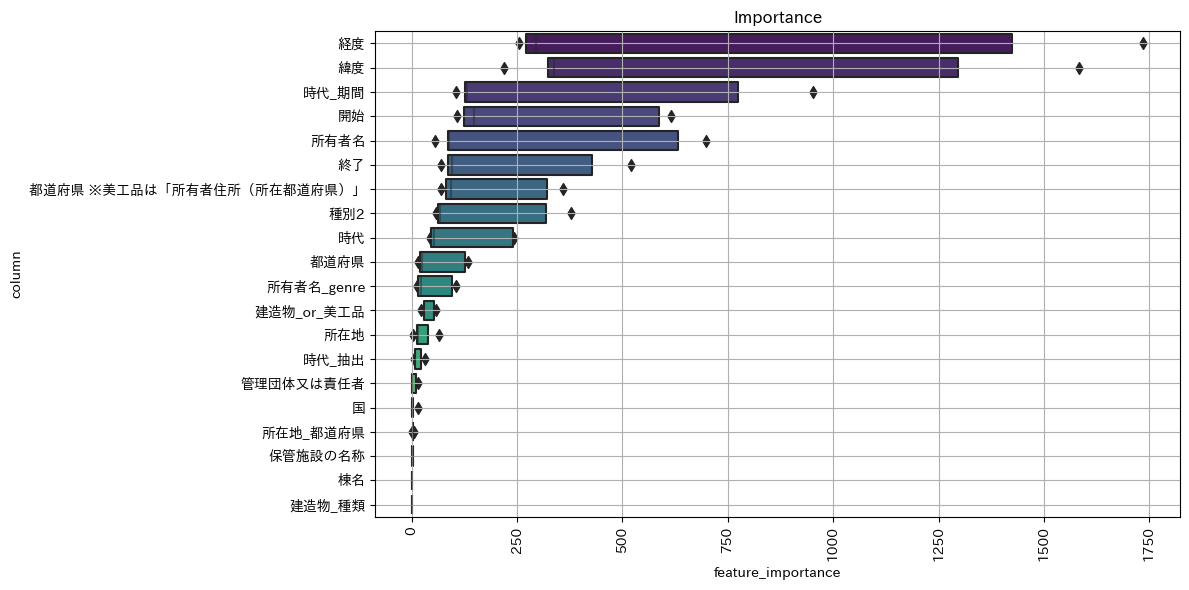

In [89]:
def visualize_importance(models: list, use_col: list) -> None:
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importance()
        _df["column"] = use_col
        _df["fold"] = i + 1
        feature_importance_df = pd.concat(
            [feature_importance_df, _df], axis=0, ignore_index=True
        )

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax


fig, ax = visualize_importance(models, use_col)

In [90]:
# k 個のモデルの予測を作成. shape = (5, N_test,).
pred = np.array([model.predict(test.select(use_col).to_pandas()) for model in models])

# k 個のモデルの予測値の平均 shape = (N_test,).
pred = np.mean(pred, axis=0)  # axis=0 なので shape の `k` が潰れる

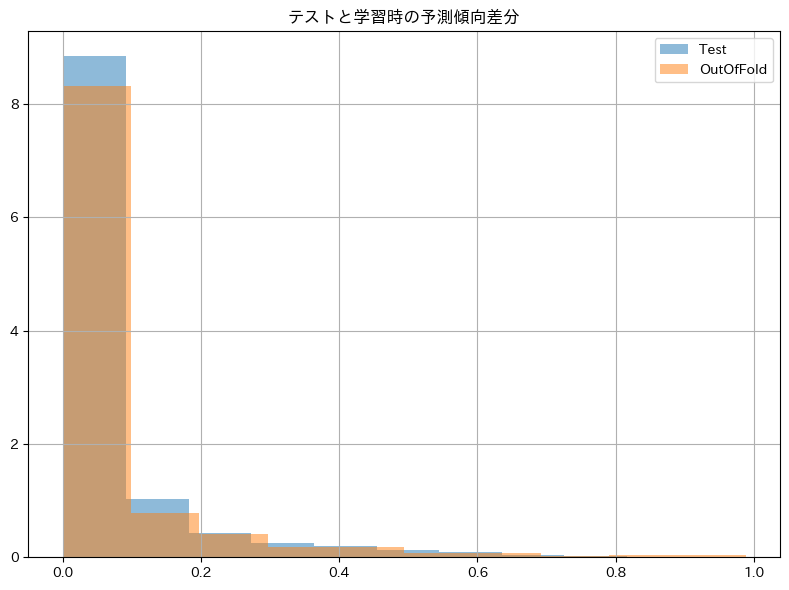

In [91]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = 0.02
# bins = np.linspace(0, 1, 0.1)
ax.hist(pred, density=True, alpha=0.5, label="Test")
ax.hist(oof, density=True, alpha=0.5, label="OutOfFold")
ax.grid()
ax.legend()
ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()

In [92]:
train.with_columns(pl.Series(oof).cast(pl.Float64).alias("oof")).write_csv(
    f"../oof/oof_{NOTEBOOK_NAME}_f1score_{max_f1_score:.4f}_auc_{oof_score:.4f}.csv"
)

In [93]:
sample_submission.with_columns(pl.Series("is_kokuhou", pred > best_thr).cast(int))

is_kokuhou
i64
0
1
1
0
0
1
1
0
0


In [94]:
sample_submission = sample_submission.with_columns(
    pl.Series("is_kokuhou", pred > best_thr).cast(int)
)
sample_submission

is_kokuhou
i64
0
1
1
0
0
1
1
0
0


In [95]:
sample_submission.write_csv(
    f"../sub/{NOTEBOOK_NAME}_f1score_{max_f1_score:.4f}_auc_{oof_score:.4f}.csv"
)